In [1]:
%pylab inline
import pandas as pd
import seaborn as sns


from helper_scripts import MetaTable
import helper_scripts as hs

from scipy.stats import ttest_ind


Populating the interactive namespace from numpy and matplotlib


In [2]:
module_table= 'https://ezmeta.unige.ch/CMGM/v1/CMGM_tables/kegg_modules.tsv'
annotations_excel= 'https://ezmeta.unige.ch/CMGM/v1/CMGM_tables/metabolism_summary.xlsx'
taxonomy_file = 'https://ezmeta.unige.ch/CMGM/v1/CMGM_tables/curated_taxonomy.tsv'

### Load metadata

We have the folowing number of samples from cold exposed (CE) and control mice at room temperature (RT) form two gut locations (Feces and Cecum).

We will concentrate on the Cecum samples

In [3]:
metadata= pd.read_table('../data/metadata_cold_exposure.tsv',index_col=0)

display(metadata.groupby(['Source','Group']).size())

metadata= metadata.query('Source=="Cecum"')

Source  Group
Cecum   CE       8
        RT       7
Feces   CE       7
        RT       6
dtype: int64

### Load taxonomy

In [4]:

# load green geens froamted taxonomy
Tax= hs.tax2table(pd.read_table('https://ezmeta.unige.ch/CMGM/v1/CMGM_tables/curated_taxonomy.tsv',
                               index_col=0,squeeze=True,header=None)
                 )

Tax.head()

,kindom,phylum,class,order,family,genus,species
0,,,,,,,
MGG00015,Bacteria,Firmicutes_A,Clostridia,Lachnospirales,Lachnospiraceae,COE1,COE1 sp002358575
MGG00022,Bacteria,Desulfobacterota,Desulfovibrionia,Desulfovibrionales,Desulfovibrionaceae,Mailhella,Mailhella sp003150275
MGG00129,Bacteria,Firmicutes_A,Clostridia_A,Christensenellales,CAG-552,MGG22630,MGG22630 MGG00129
MGG00141,Bacteria,Firmicutes_A,Clostridia,Lachnospirales,Lachnospiraceae,MGG00141,MGG00141 MGG00141
MGG00234,Bacteria,Firmicutes_A,Clostridia_A,Christensenellales,Borkfalkiaceae,UBA11940,UBA11940 MGG00234


### Load abundance data

The median coverage is used to calculate relative abundance. But for the differencial abundance testing we use centered log ratio of the raw coverage values, because sequencing data is compositional. See more on [compostional data analyis](https://en.wikipedia.org/wiki/Compositional_data)

In [5]:
counts_all= pd.read_table('../data/counts_genomes.tsv.gz',index_col=0)

coverage_all= pd.read_table('../data/median_coverage_genomes.tsv.gz',index_col=0)


In [6]:

# a species needs to be at least 50% covered in one sample
coverage= coverage_all.loc[metadata.index,coverage_all.max()>0.5]

#calcualte relative abundance of genomes
relab= (coverage.T / coverage.sum(1)).T *100

counts= counts_all.loc[metadata.index,coverage.columns]

# transform counts with centered log2 ratio (for more info see link above)
clr_data= hs.clr(counts,log=np.log2)

## Create metadata to calulate differencial abundance

In [7]:

def calulate_statistics(data):
    stats= data.groupby(metadata.Group).mean().T.rename(columns= lambda s: 'Mean '+s)
    # we use welch test for statistical analysis
    
    two_groups= tuple(d for _,d in  data.groupby(metadata.Group))
    assert len(two_groups)==2, "grouping of data in two groups failed"
    
    _, stats['Pvalue']=   ttest_ind(*two_groups,equal_var=False)
    # correct for multiple testing
    stats['pBH']= hs.Significance.correct_pvalues_for_multiple_testing( stats.Pvalue)


    return stats

genom_stats= calulate_statistics(clr_data)

# as the data in log2 the difference between the means is the log FC
genom_stats['logFC']= genom_stats['Mean CE'] - genom_stats['Mean RT']
genom_stats.sort_values('logFC')

genom_stats['logP'] = -genom_stats.pBH.apply(np.log10)
genom_stats= genom_stats.join(Tax[['phylum','family','species']])

,Mean CE,Mean RT,Pvalue,pBH,logFC,logP,phylum,family,species
MGG49466,-1.442784,2.514198,1.547703e-07,0.000032,-3.956982,4.498558,Bacteroidota,Muribaculaceae,UBA7173 sp002491305
MGG49661,-4.429922,2.306635,1.517287e-07,0.000032,-6.736557,4.498558,Actinobacteriota,Atopobiaceae,NM07-P-09 sp004793665


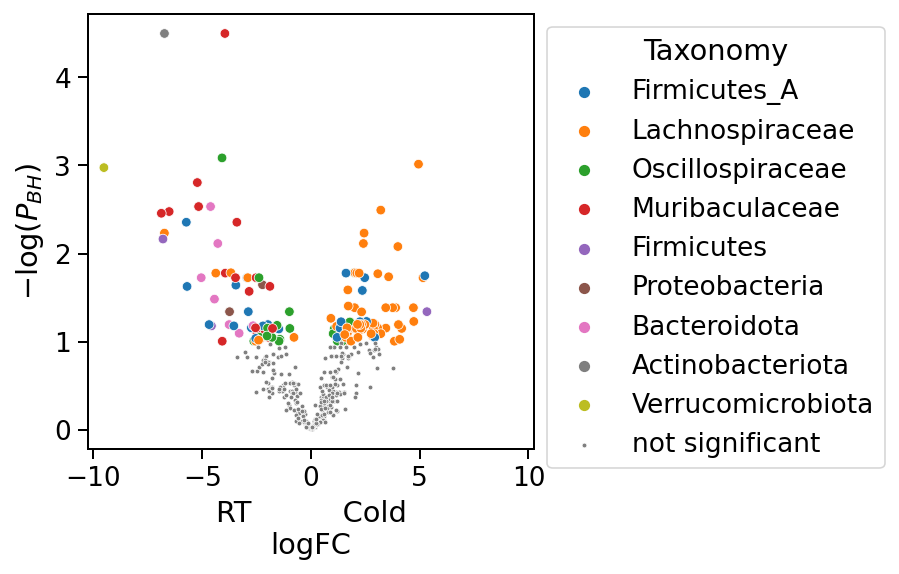

In [8]:
hs.plotting.plotting_Setup(save_dpi=300)

f= plt.figure(figsize=(4,4))


hue= genom_stats.phylum.copy()    
for family in ['Lachnospiraceae','Oscillospiraceae','Muribaculaceae']:
    hue.loc[genom_stats.family==family]=family
hue.loc[genom_stats.logP<1]=None 

ax=sns.scatterplot(y='logP',x= 'logFC' ,data=genom_stats,
               hue= hue, alpha=1)

ax=sns.scatterplot(y='logP',x= 'logFC' ,data=genom_stats.loc[hue.isnull()],
                   color='grey',marker='.',
                   label='not significant'
               )


ax.set_xlabel('RT'+' '*10+'Cold'+'\nlogFC')
ax.legend(bbox_to_anchor=(1,1),title='Taxonomy') 
ax_lim= np.abs(ax.get_xlim()).max()
ax.set_xlim([-ax_lim,ax_lim])
ax.set_ylabel('$-\log(P_{BH})$');


hs.plotting.saveplot('CE_species_vulcanoplot',figurefolder='/Users/silas/Desktop/MAGcatalog/Figures/',formats=['.svg','.png'])

genom_stats.query('logP>4')



## load modules

In [9]:
module_table= pd.read_table(module_table, index_col=[1,2])
module_matrix= module_table.step_coverage.unstack(fill_value=0)
module_matrix= module_matrix.loc[:, module_matrix.max()>0.1]

module_names = module_table.droplevel(0).module_name.drop_duplicates()

In [10]:
# Define module threshold by a threshold

threshold= 0.75

module_presence = (module_matrix > threshold) *1
#drop all 0 modules
module_presence= module_presence.loc[:,module_presence.max()>0]




Text(0.5, 0.98, 'Module coverage above threshold')

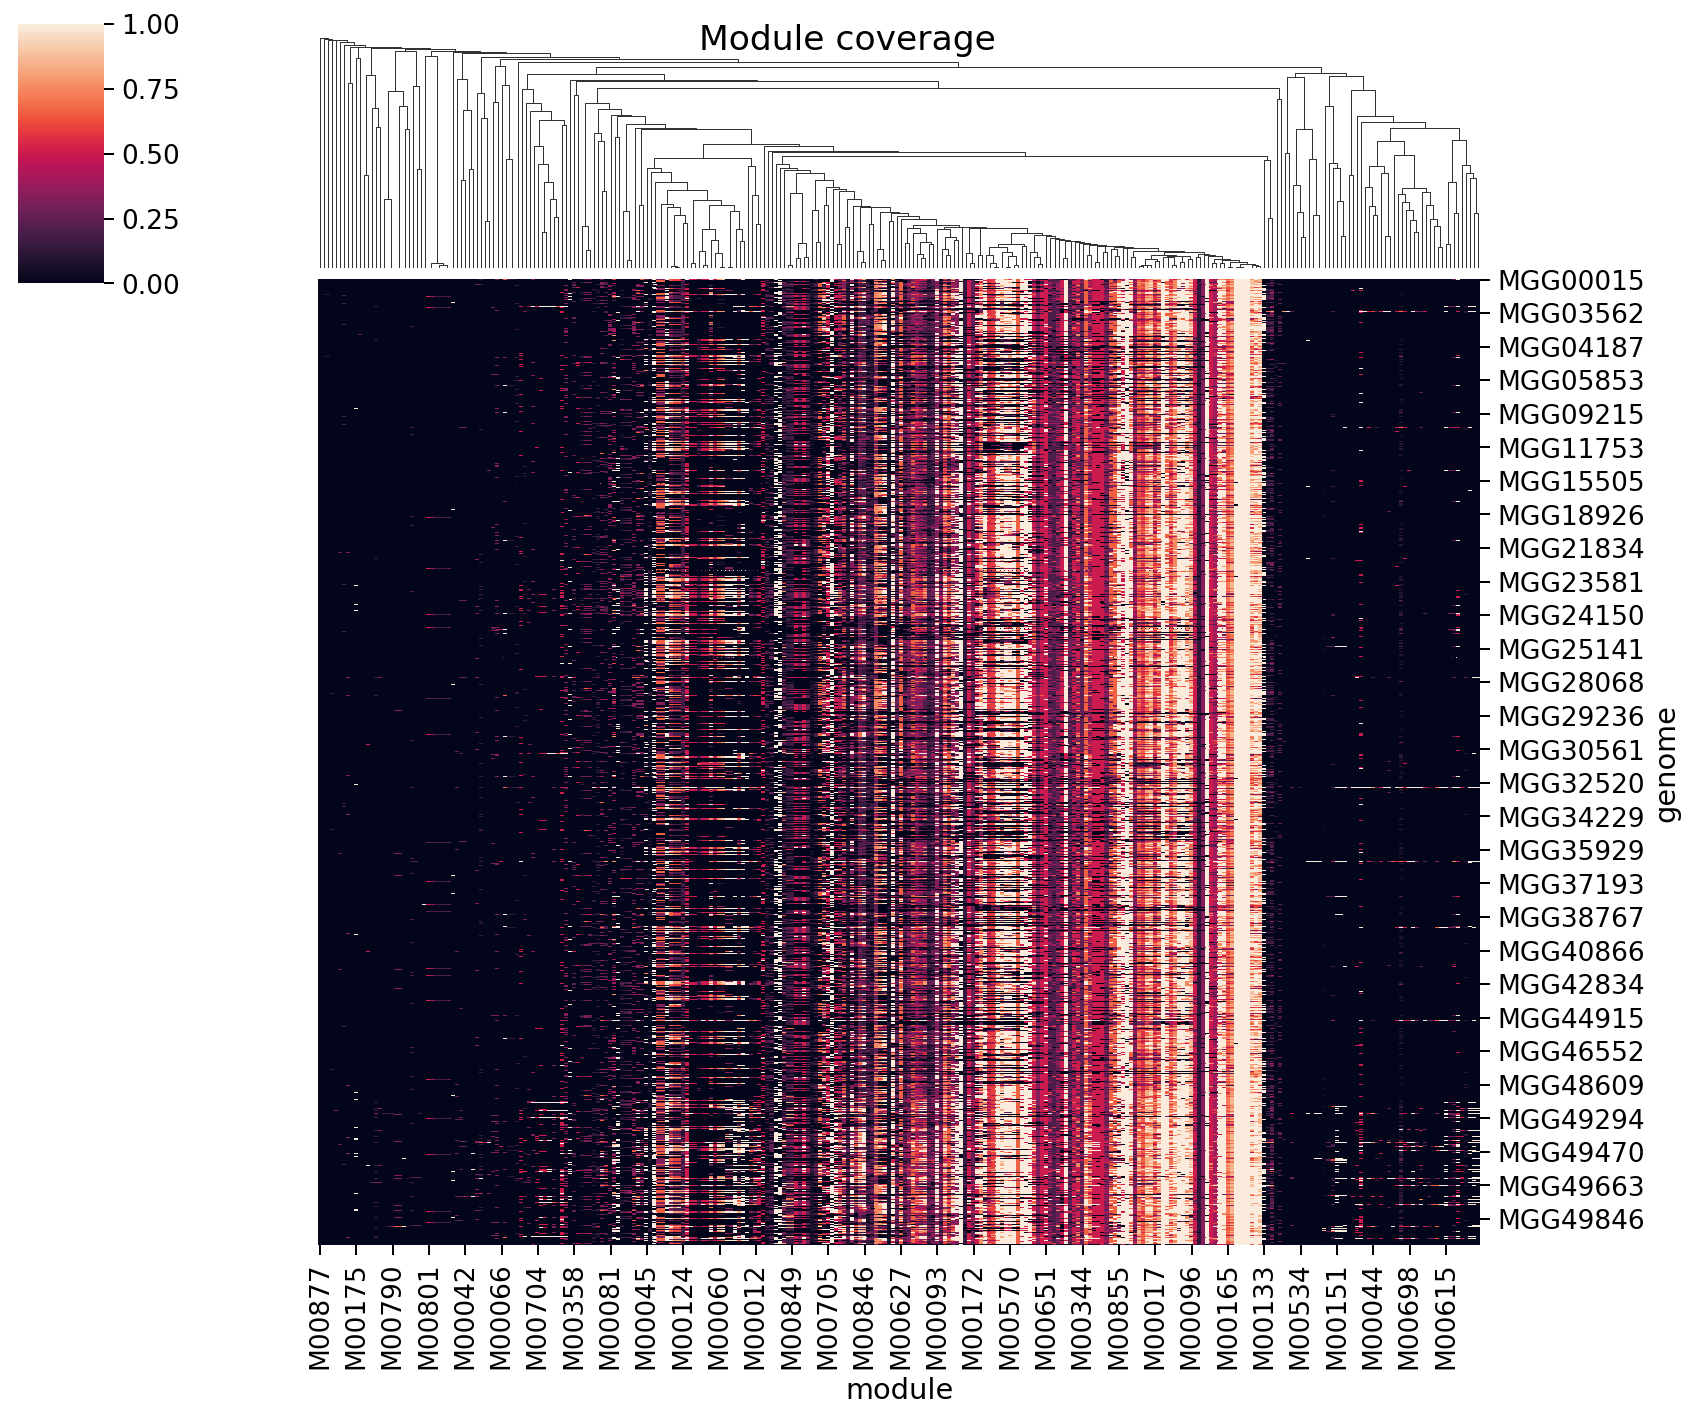

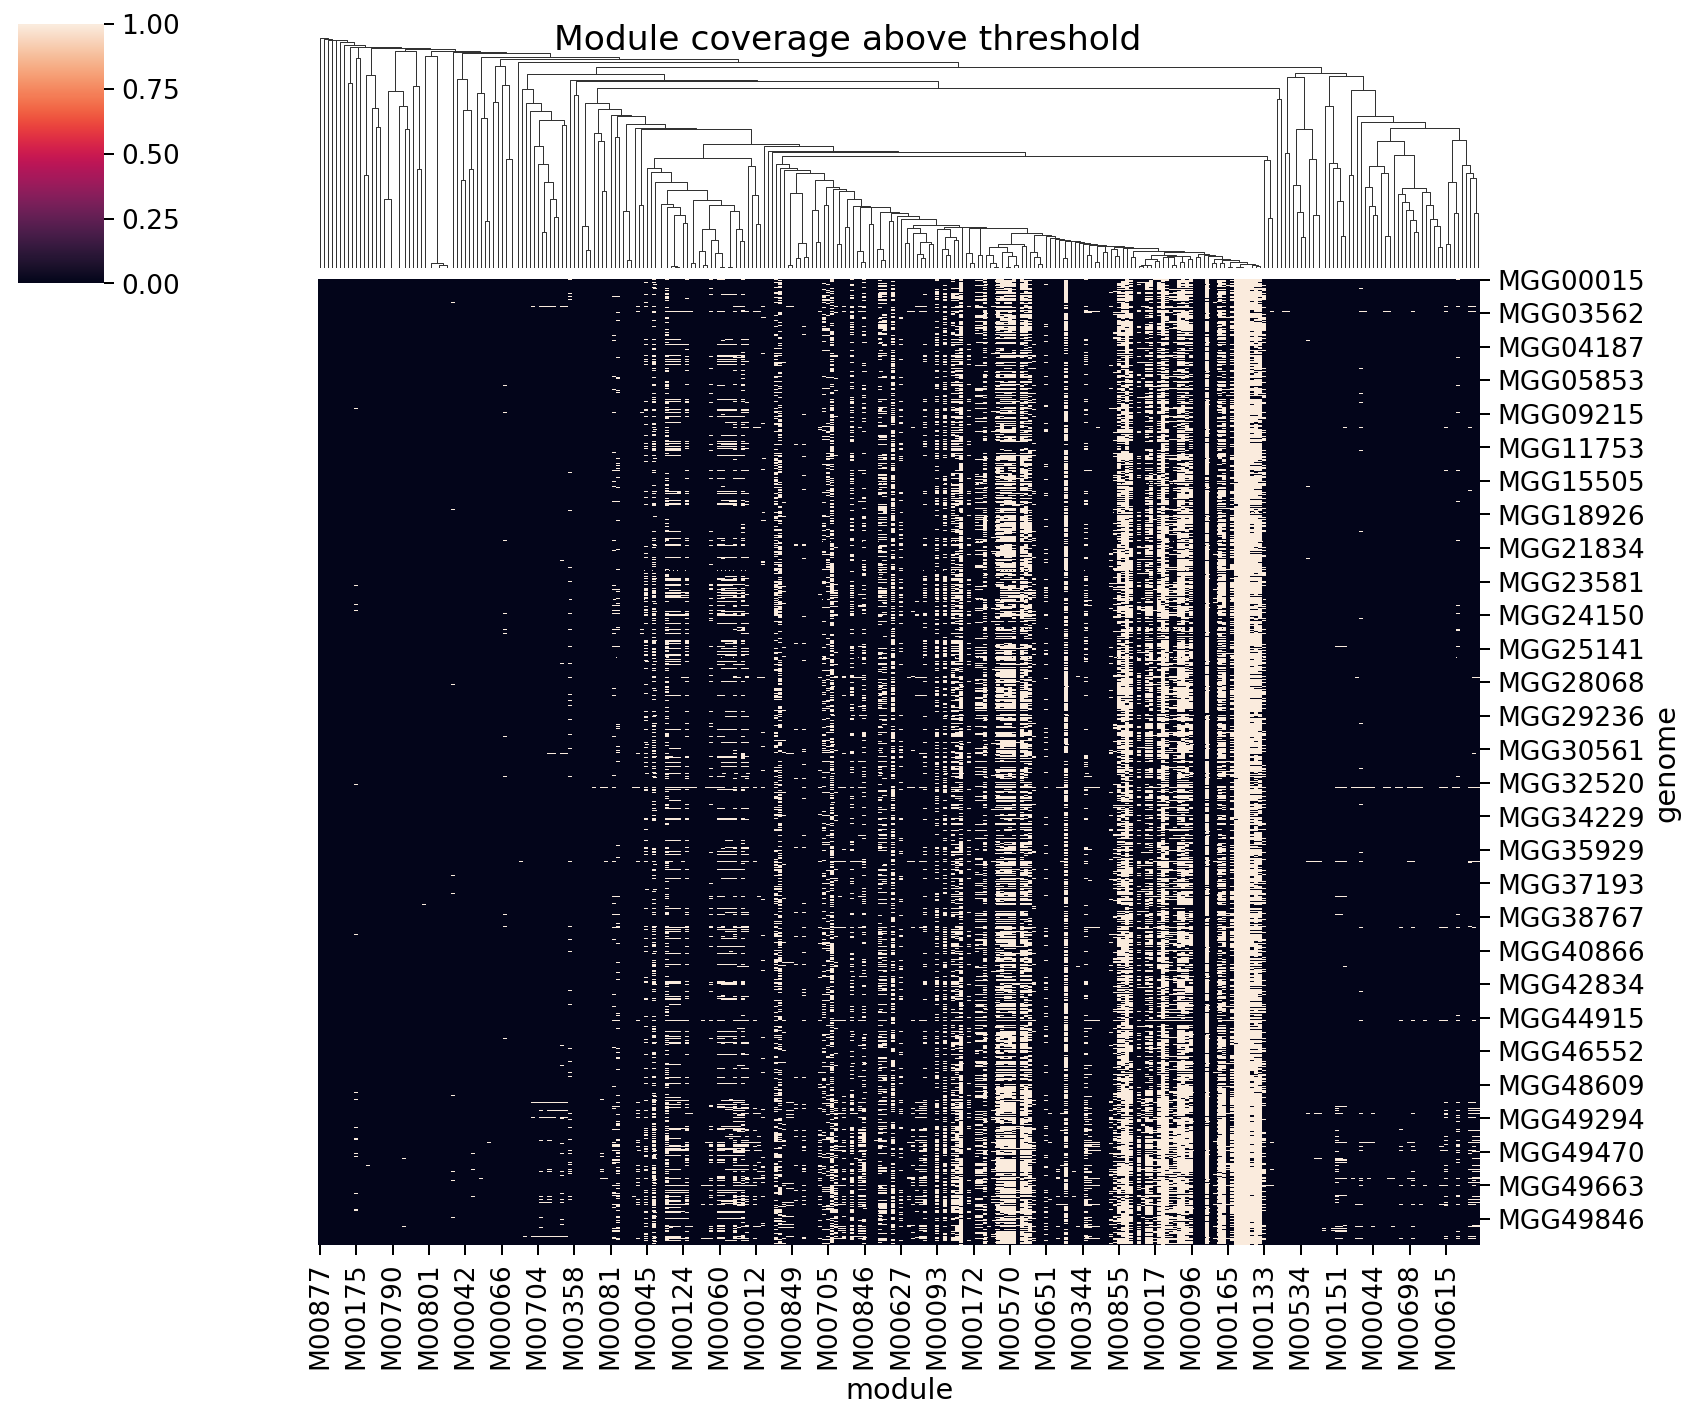

In [11]:
cgi= sns.clustermap(module_matrix,metric='cosine',figsize=(12,10),row_cluster=False)

cgi.fig.suptitle('Module coverage')

cgi_bin=sns.clustermap(module_matrix> threshold,
                   figsize=(12,10),
                   row_cluster=False,
                       col_linkage= cgi.dendrogram_col.linkage
                  )
cgi_bin.fig.suptitle('Module coverage above threshold')


As no modules for short-chain-fatty acids are in Kegg we creat our own. 


In [12]:
#this can take some time
A, annotation_description= hs.read_dram_annotation_summary(annotations_excel)

100%|██████████| 6/6 [01:57<00:00, 19.54s/it]


In [13]:




paths_for= {'Propanoate' : [('K19697','K00932'),'K01026','K01895','K01908'],
            'Butyrate': [('K01034','K01034'),('K00929','K00634')] ,
            'Acetate': ['K01067','K00156','K00925','K01512','K00467'],
            'Lactate': ['K00016']
           }
                     
                    
F = pd.DataFrame(index=A.index)

for function in paths_for:

    F[function]= False

    for ko_list in  paths_for[function]:

        if type(ko_list)==str:
            ko_list = [ko_list]

            
        F[function] |= A.reindex(columns=ko_list,fill_value=False).all(1)

module_presence= pd.concat( (module_presence,F.astype(int)),axis=1)

for scfa in F.columns:
    module_names[scfa]= scfa+' metabolism'

## Calculate module abundance
calulate module abundance as the sum of relative abundance of species containing the module
We do this with a matrix multiplication

In [14]:


module_abundance = relab @ module_presence.loc[relab.columns]
module_abundance= module_abundance.loc[:,module_abundance.max()>0]

In [15]:
stats= calulate_statistics(module_abundance)

stats['Name']= module_names

stats['log2FC']= - stats[['Mean CE', 'Mean RT']].apply( lambda x: np.log2(x+1e-5) ).diff(axis=1).iloc[:,1]

In [16]:
hit_table= stats.query("pBH<0.05 & abs( log2FC ) >1").sort_values('log2FC')
hit_table

Group,Mean CE,Mean RT,Pvalue,pBH,Name,log2FC
M00124,0.076070,0.412625,0.017961,0.040852,"Pyridoxal biosynthesis, erythrose-4P => pyrido...",-2.439269
M00086,9.933781,34.501197,0.000683,0.004167,"beta-Oxidation, acyl-CoA synthesis",-1.796230
M00060,12.741608,38.000628,0.000136,0.002845,"KDO2-lipid A biosynthesis, Raetz pathway, LpxL...",-1.576475
M00052,15.211721,42.666567,0.000076,0.002845,"Pyrimidine ribonucleotide biosynthesis, UMP =>...",-1.487922
M00127,16.574981,44.630428,0.000059,0.002845,"Thiamine biosynthesis, AIR => thiamine-P/thiam...",-1.429020
M00577,14.644182,38.583112,0.000343,0.002845,"Biotin biosynthesis, BioW pathway, pimelate =>...",-1.397641
M00123,14.644182,38.583112,0.000343,0.002845,"Biotin biosynthesis, pimeloyl-ACP/CoA => biotin",-1.397641
M00573,14.644182,38.583112,0.000343,0.002845,"Biotin biosynthesis, BioI pathway, long-chain-...",-1.397641
M00572,5.911040,14.993449,0.002756,0.010311,"Pimeloyl-ACP biosynthesis, BioC-BioH pathway, ...",-1.342847
M00153,24.324245,56.429613,0.000188,0.002845,Cytochrome bd ubiquinol oxidase,-1.214057


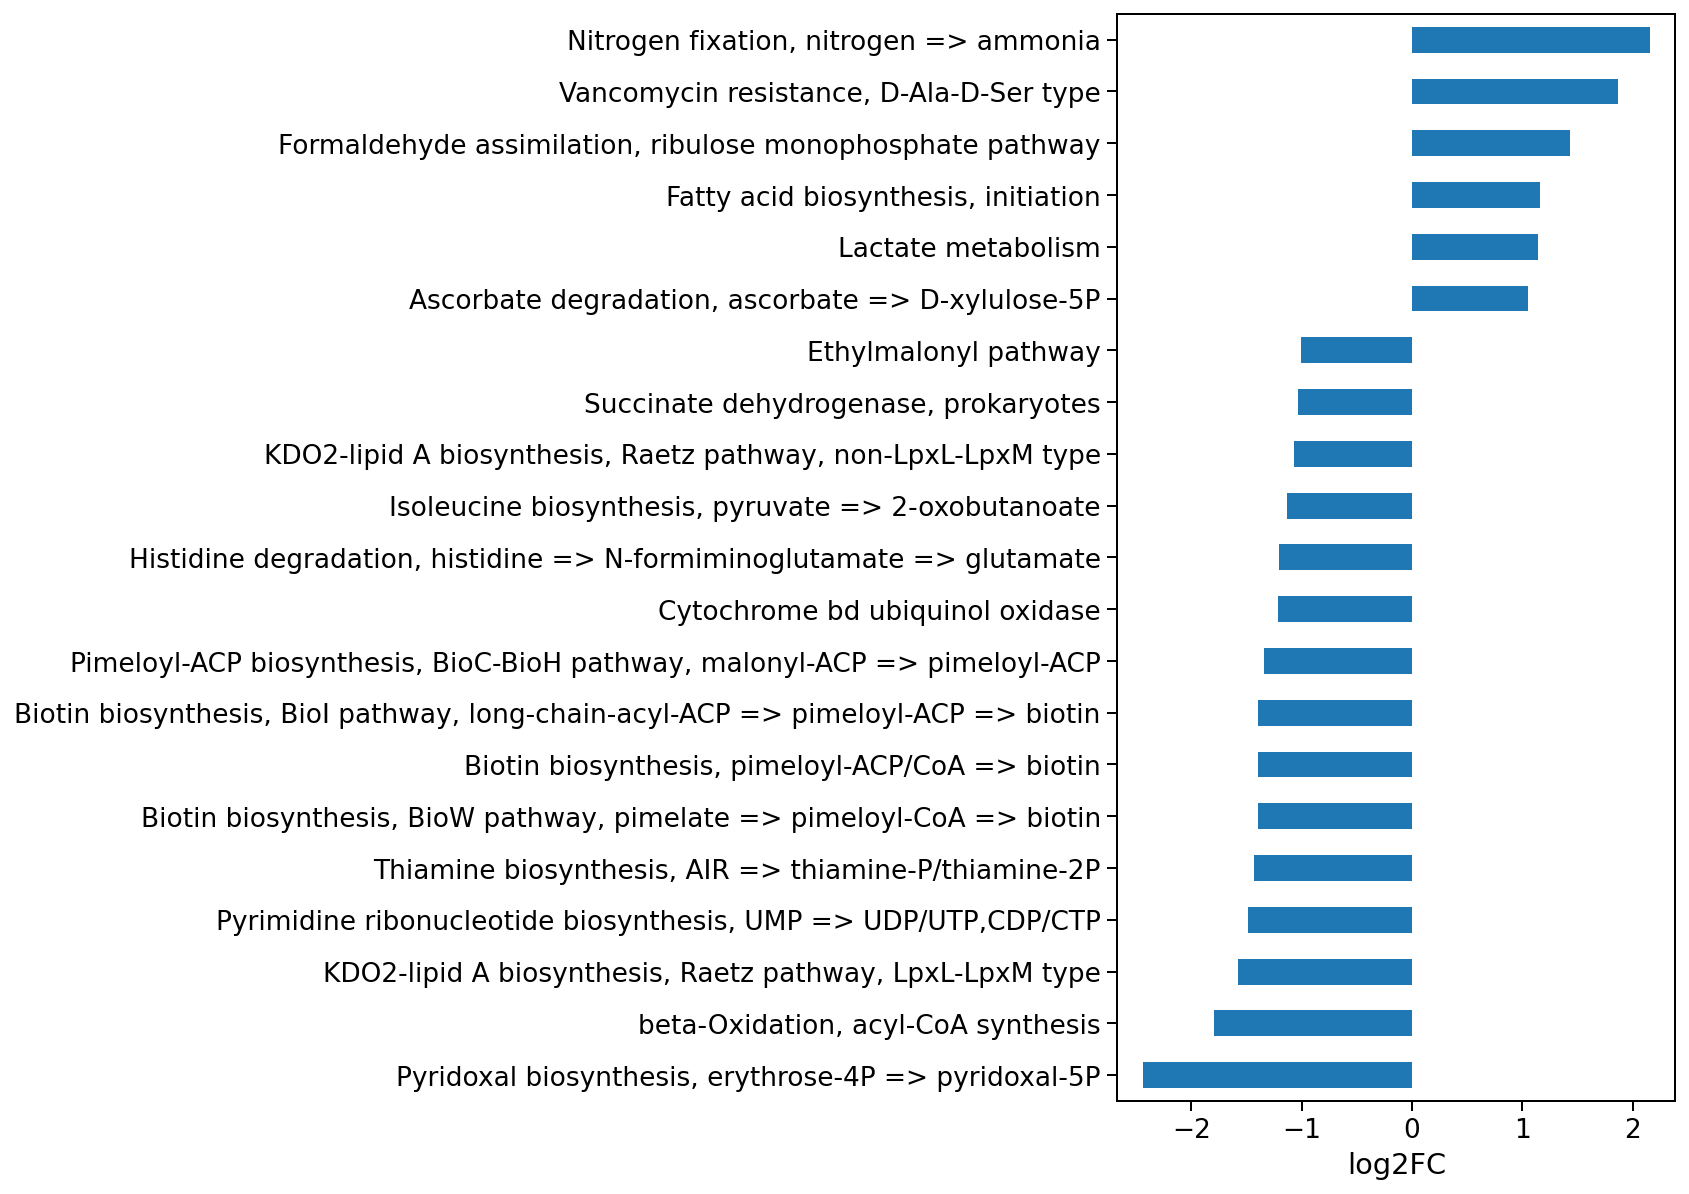

In [17]:
ax=hit_table.log2FC.plot.barh(figsize=(5,10))
ax.set_yticklabels(hit_table.Name);
ax.set_xlabel('log2FC');

/Users/silas/Documents/GitHub/CMGM/notebooks/helper_scripts/microbiota.py:147: UserWarning: May be your data is not in the right orientation sample x feature
  warnings.warn("May be your data is not in the right orientation sample x feature")


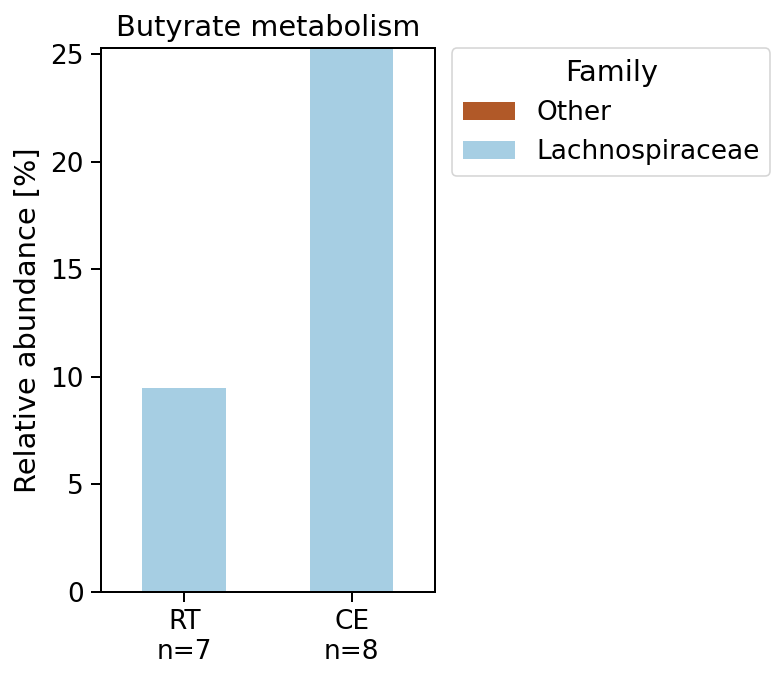

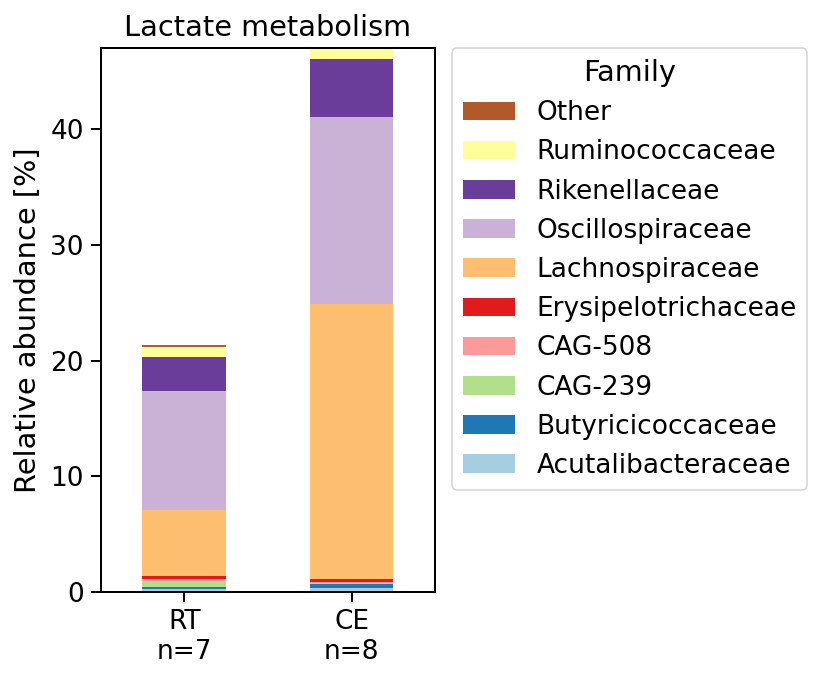

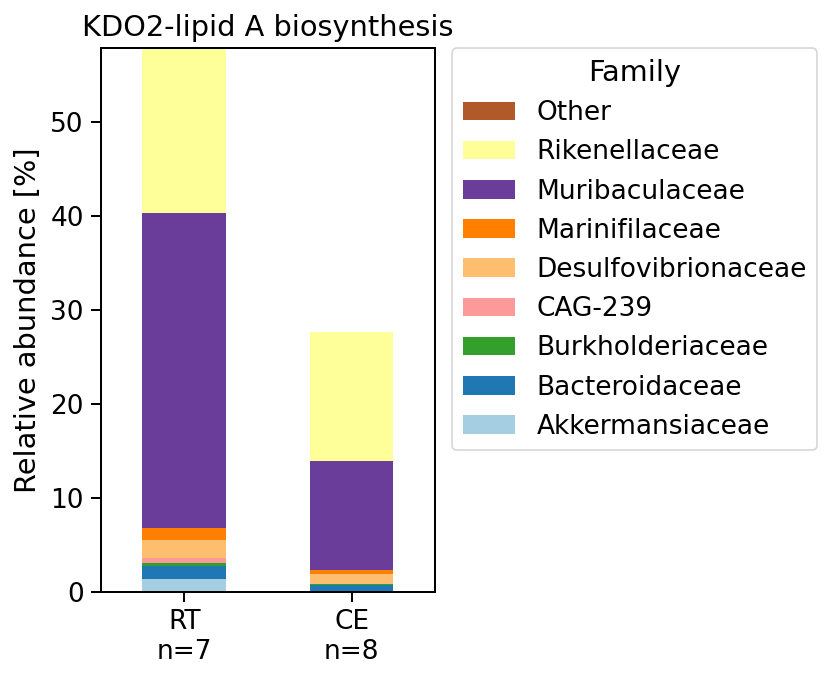

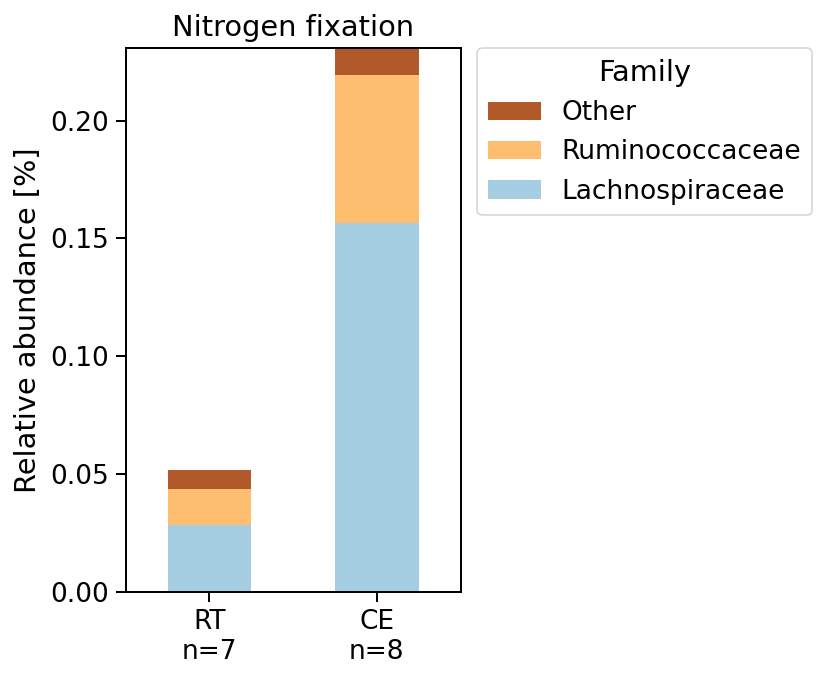

In [18]:


level='family'
for module_of_interest in ['Butyrate','Lactate', 'M00866','M00175' ]:


    genomes_for_module= module_presence[module_of_interest]==1
    average_abundance= relab.loc[:,genomes_for_module].groupby(Tax[level],axis=1).sum()

    ax=hs.bubble.MeanGroup_Barplot(average_abundance,metadata.Group,filtervalue=10,order=['RT','CE'],figsize=(3, 5))

    ax.set_title(module_names.loc[module_of_interest].split(',')[0],loc='center')
    ax.set_ylabel('Relative abundance [%]')
    ax.legend_.set_title(level[0].upper()+level[1:])
    plt.show()
